0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ
(8, 64, 128, 3)
32
Use Cuda.....
總共參數： 16972133
目前Loss：  3.8554697
目前Loss：  3.7607758
目前Loss：  3.7981105
目前Loss：  3.8860607
目前Loss：  3.8110266
目前Loss：  3.734312
目前Loss：  3.6395462
目前Loss：  3.8293128
目前Loss：  3.874849
目前Loss：  3.6574955
Prediction:  GG
Ground_Truth:  NZ7V


Text(0.5, 1.0, 'NZ7V')

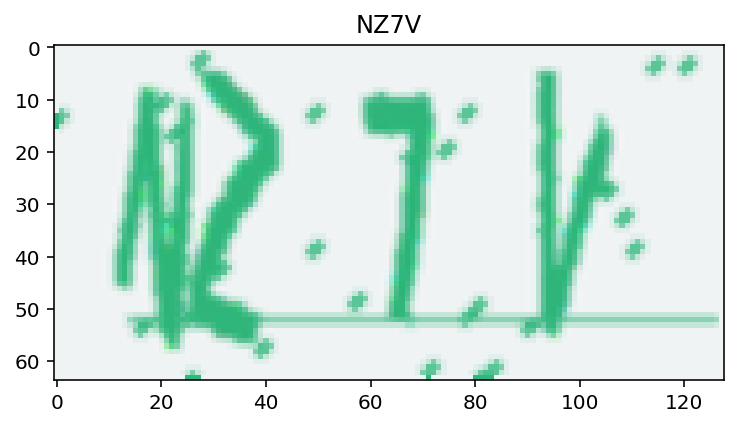

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random
import string

from torch.autograd import Function
from torch.autograd import Variable
from captcha.image import ImageCaptcha ##隨機產生驗證碼，可以先用 pip install captcha

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## characters='0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
## 二十六個字母+0-9的數字
characters = string.digits + string.ascii_uppercase
print(characters)

##  設定 寬高=126,64的影像，並且包含4個字
width, height, n_len, n_class = 128, 64, 4, len(characters)


## 產生Captcha
generator = ImageCaptcha(width=width, height=height)

## 字從characters中36個字符隨機選取
random_str = ''.join([random.choice(characters) for j in range(n_len)])
img = generator.generate_image(random_str)

plt.imshow(img)
plt.title(random_str)

n=1 ## 初始值為1是由於保留0的位置給CTC的空格，所以除了原本36個class外，會加上空格變成37個class
character_index={} ## character對照標籤字典
index_character={} ## 標籤對照character字典
for character in characters:
    character_index[character]=n
    index_character[n]=character
    n+=1
  


def gen(batch_size=8):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    generator = ImageCaptcha(width=width, height=height)
    while True:
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(4)])
            X[i] = generator.generate_image(random_str)
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, characters.find(ch)] = 1
        data_list=[]     
        for single in range(batch_size):
            for data in y:
                w=np.argmax(data[single,:])+1
                data_list.append(w)   
        yield X, data_list ## X == input images, data_list=list of label 

Loader=gen(batch_size=8)
#next(Loader) 產生資料

## 8張驗證碼，每張影像size= (64, 128, 3)
print(next(Loader)[0].shape)
## label是一個list，長度為32
print(len(next(Loader)[1]))

import torch
import torch.nn as nn

## CNN Backbone
def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif v == 'C':
            layers += [nn.MaxPool2d(kernel_size=2, stride=(2,1))]
  
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

##定義 Bidirectional GRU
class BiRNN_GRU(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes,drop=0.3):
        super(BiRNN_GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.drop=drop
        self.GRU = torch.nn.GRU(input_size,hidden_size, num_layers,batch_first=False,dropout=self.drop,
                              bidirectional=True)
        self.fc = torch.nn.Linear(hidden_size*2, num_classes)  # 2 for bidirection

    def forward(self, x):
        # Forward propagate LSTM
        out, _ = self.GRU(x)# out: tensor of shape (batch_size, seq_length, hidden_size*2)
        #print(out.shape)
        # Decode the hidden state of the last time step
        out = self.fc(out)
        return out
    
class CRNN(nn.Module):
    def __init__(self, features, num_classes=37, init_weights=True):
        super(CRNN, self).__init__()
        self.features = features
        self.GRU_First=BiRNN_GRU(512,256,2,256,0.3)
        self.GRU_Second=BiRNN_GRU(256,256,2,256,0.3)
        self.output=torch.nn.Linear(256,num_classes) 
        
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.squeeze(2).permute(2,0,1)
        x = self.GRU_First(x)
        x = self.GRU_Second(x)
        x = self.output(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


cfgs = { 'backbone': [64, 64, 'M', 128, 128, 'C', 256, 256, 256, 'C', 512, 512, 'C', 'M', 512, 512, 512, 'M'],}

def CRNN_BN(config,batch_norm = True, **kwargs):

    return CRNN(make_layers(config['backbone'], batch_norm=batch_norm), **kwargs)
  
model = CRNN_BN(cfgs) 

if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    model =model.cuda()
    cuda=True
    print('Use Cuda.....')
else:
    torch.set_default_tensor_type('torch.FloatTensor')
    cuda=False
    print('Use Cpu......')


ctc_loss = torch.nn.CTCLoss(blank=0,reduction='mean',zero_infinity=True) ## 設置CTC Loss


model.train()
batch_size_=8
optimizer = optim.Adam(model.parameters(),lr=0.01/batch_size_)

model_parameters = filter(lambda p: p.requires_grad, model.train().parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('總共參數：' ,params)

input_lengths=torch.tensor([15 for _ in range(batch_size_)],dtype=torch.long) ## output width看成timestep
target_lengths=torch.tensor([4 for _ in range(batch_size_)],dtype=torch.long) ## 每一筆資料的標籤長度，可以浮動，但在我們case中是固定長度4

n=0
for iteration in range(5000):
    X_train,target=next(Loader)
    X_train=X_train/127.5-1
    if cuda:
        X_train=Variable(torch.tensor(X_train).type(torch.cuda.FloatTensor))
    else:
        X_train=Variable(torch.tensor(X_train).type(torch.FloatTensor))
    X_train=X_train.permute(0,3,1,2)

    target=Variable(torch.tensor(target,dtype=torch.long))

    optimizer.zero_grad()

    output=model(X_train)
    n+=1

    out=torch.nn.functional.log_softmax(output,dim=2) #np.log(F.softmax(torch.tensor([0.1,1,0.9])))
    loss=ctc_loss(out,target,input_lengths,target_lengths)
    loss.backward()
    optimizer.step()


    if n%500==0:  
        print('目前Loss： ',loss.data.cpu().numpy())
#torch.save(MobileNetV3_net.state_dict(),'weights/CTC'+'.pth')



generator = ImageCaptcha(width=width, height=height)
random_str = ''.join([random.choice(characters) for j in range(n_len)])
img = generator.generate_image(random_str)

img_input = np.array(img)
if cuda:
    img_input=Variable(torch.tensor(img_input).type(torch.cuda.FloatTensor).unsqueeze(0)).permute(0,3,1,2)
else:
    img_input=Variable(torch.tensor(img_input).type(torch.FloatTensor).unsqueeze(0)).permute(0,3,1,2)
    
output=model(img_input)
output=F.softmax(output,2)

word=''
n=0
count=0
## 其中0代表預測為空格，如果預測相同字符之間沒有空格要移除
for word_result in output.squeeze(1).argmax(1):
    character_index=word_result.item()
    if character_index>0:
        if n!=character_index:
            word+=index_character[character_index]
    n=character_index 
    count+=1
print('Prediction: ',word)
print('Ground_Truth: ',random_str)
plt.imshow(img)
plt.title(random_str)

In [2]:
!pip install captcha

     |################################| 101 kB 2.8 MB/s ta 0:00:011
You should consider upgrading via the '/miniconda/envs/py36/bin/python -m pip install --upgrade pip' command.
